In [3]:
# Magic line to force reload all modules when this cell is run multiple times
%load_ext autoreload
%autoreload 2

import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.offline import plot
import ipywidgets as widgets

# %matplotlib widget
py.offline.init_notebook_mode(connected=True)

In [4]:
import numpy as np
import pandas as pd
import umap

from ClusterPipeline import ClusterPipeline
from helper import split_valid, plot_confusion_matrix
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler


np.random.seed(seed=42) 

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



In [5]:
X,y = make_classification(n_samples=1000, n_classes=3, weights=[0.5,0.25,0.25], n_features=10,
                          n_informative=5, n_redundant=5, class_sep=0.7, n_clusters_per_class=1,
                          hypercube=True, shuffle=True, random_state=42)

In [6]:
data = pd.DataFrame(X)
labels = pd.Series(y)
# data.hist(figsize=(20,12))

# Separating a hold out set that will be used for validation of the pipeline
train_data, train_labels, test_data, test_labels = split_valid(data, labels, valid_size=0.5)


# original_labels = train_labels.copy()
# train_labels[train_labels > 0] = 1
train_labels.value_counts()

0    248
2    126
1    126
dtype: int64

In [7]:
test_data.shape

(500, 10)

### Note: The labels used for the split are training and NOT original
> ###  Sublcusters may be imbalanced 

In [8]:
X_train = train_data
y_train = train_labels.copy()
y_train[y_train > 0] = 1

X_valid = test_data
y_valid = test_labels.copy()
y_valid[y_valid > 0] = 1

In [9]:
y_train.value_counts()

1    252
0    248
dtype: int64

In [10]:
# X_train, y_train, X_valid, y_valid = split_valid(train_data, train_labels, valid_size=0.5)

In [11]:
def build_dnn(num_features, num_nodes = 16, depth = 2, num_labels=2, activation = "elu"):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    keras.backend.clear_session()
    
    reg_scale = 0.001 # For L1 Reg
    my_reg = regularizers.l1(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = keras.initializers.he_normal()
    
    dnn.add(Dense(units = 10, activation="elu", input_dim=num_features,
                  kernel_initializer=keras.initializers.he_normal(), kernel_regularizer = regularizers.l1(reg_scale)))
    dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units = 10, activation="elu",
                  kernel_initializer=keras.initializers.he_normal(), kernel_regularizer = regularizers.l1(reg_scale)))
    dnn.add(keras.layers.Dropout(0.5))
#     dnn.add(Dense(units = 5, activation="elu",
#                   kernel_initializer=keras.initializers.he_normal(), kernel_regularizer = regularizers.l1(reg_scale)))
#     dnn.add(keras.layers.Dropout(0.5))

    
    dnn.add(Dense(units=num_labels, activation="softmax",
                  kernel_initializer=he_init, kernel_regularizer = my_reg)) # 5 labels -> logits for now
    
#     nadam = keras.optimizers.Nadam()
    NSGD = keras.optimizers.SGD(lr=0.01,momentum=0.9,nesterov=True)
    
    dnn.compile(loss='categorical_crossentropy',
                  optimizer=NSGD,
                  metrics=['accuracy'])
    
    return dnn

In [13]:
reducer = umap.UMAP(random_state=42,
                    n_components = 10,
                    n_neighbors=125,
                    min_dist=0)

In [14]:
nn = build_dnn(num_features=train_data.shape[1])
pipeline = ClusterPipeline(nn, [X_train, y_train], [X_valid,y_valid], target_class=1, reducer=reducer)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Using TensorFlow backend.


Running Serial Crossvalidation
Running worker: 0
Instructions for updating:
Use tf.cast instead.
Fold: 0 -> Loss:0.382, Acc:0.8753
Prediction Accuracy
51/51 [==============================] - 0s 833us/step
Scores on data set: loss=0.189 accuracy=0.9608
Fold Correct: 49
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Running worker: 1
Fold: 1 -> Loss:0.386, Acc:0.8864
Prediction Accuracy
51/51 [==============================] - 0s 32us/step
Scores on data set: loss=0.245 accuracy=0.9412
Fold Correct: 48
Running worker: 2
Fold: 2 -> Loss:0.319, Acc:0.8933
Prediction Accuracy
50/50 [==============================] - 0s 29us/step
Scores on data set: loss=0.309 accuracy=0.9200
Fold Correct: 46
Running worker: 3
Fold: 3 -> Loss:0.341, Acc:0.8867
Prediction Accuracy
50/50 [==============================] - 0s 33us/step
Scores on data set: loss=0.231 accuracy=0.9600
Fold Correct: 48
Running worker: 4
Fold: 4 -> Loss:0.369, Acc:0.8889
Prediction Accuracy
50/50 [===

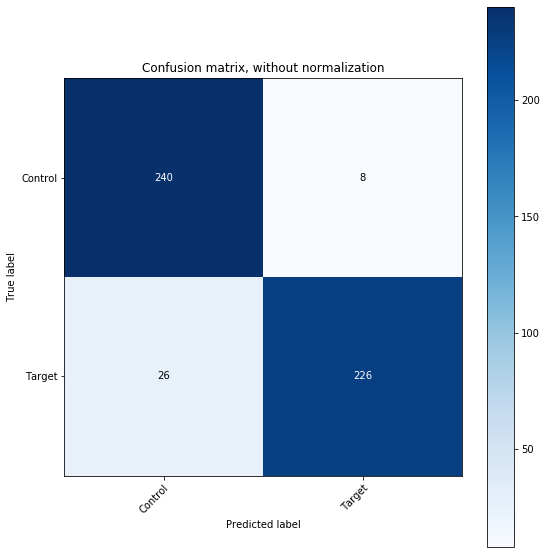

In [15]:
cm = pipeline.train_model(batch_size=20,epochs=50, cross_validation=True, parallel=False, verbose=0)

In [18]:
from sklearn.preprocessing import MinMaxScaler
reducer = umap.UMAP(random_state=42,
                    n_components = 10,
                    n_neighbors=25,
                    min_dist=0)

pipeline.reducer_pipeline = Pipeline([
            ("umap", reducer),
            ("scaler",  MinMaxScaler())
        ])

_, correct_pred_idxs = pipeline.train_clusterer(plot=False)

Cluster Search Space: range(23, 27)
Minimum Size:
Clusters                  (23, 23)
Noise                     (23, 23)
Halkidi                   (25, 25)
Halkidi-Filtered Noise    (26, 26)
dtype: object


In [19]:
print("Clusters Found:", max(pipeline.clusterer.labels_)+1)

Clusters Found: 2


In [20]:
# sum(pipeline.training_lrp[0])

In [21]:
def plot_clusters(pipeline):
    
    training_lrp = pipeline.training_lrp
    
    # Internally populates self.val_set_lrp
    samples, cluster_labels = pipeline.get_validation_clusters()
    
    val_lrp = pipeline.val_set_lrp
    # pipeline.reducer_pipeline[0].n_neighbors
    embedding_pipeline = Pipeline([
        ("reducer", umap.UMAP(random_state=42,
                        n_components = 3,
                        n_neighbors=160,
                        min_dist=0)),
       ("scaler", MinMaxScaler())
    ])
    embedding_pipeline.fit(training_lrp)

    embedding = embedding_pipeline.transform(training_lrp)

    emb3d = go.Scatter3d(
        x=embedding[:,0],
        y=embedding[:,1],
        z=embedding[:,2],
        mode="markers",
        name="Training",
        marker=dict(
            size=2,
            color=pipeline.clusterer.labels_,
            colorscale="Rainbow",
            opacity=0.8,
            showscale=True
        ),
        text=pipeline.clusterer.labels_
    )

#     val_3d_embedding = embedding_pipeline.transform(val_lrp)

#     val_emb3d = go.Scatter3d(
#         x=val_3d_embedding[:,0],
#         y=val_3d_embedding[:,1],
#         z=val_3d_embedding[:,2],
#         name="Validation",
#         mode="markers",
#         marker=dict(
#             size=3,
#             color=cluster_labels,
#             colorscale='Viridis',
#             opacity=0.8,
#             showscale=True
#         ),
#         text = cluster_labels
#     )

    layout = go.Layout(
        title="3D LRP Embedding",
        autosize=False,
        width=1200,
        height=1000,
        paper_bgcolor='#F5F5F5',
    #     template="plotly"
    )


    data=[emb3d]

    fig = go.Figure(data=data, layout=layout)
    # fig.update_layout(template="plotly")  /

    iplot(fig, filename='lrp-3d-scatter.html')

Prediction Accuracy: 0.9560


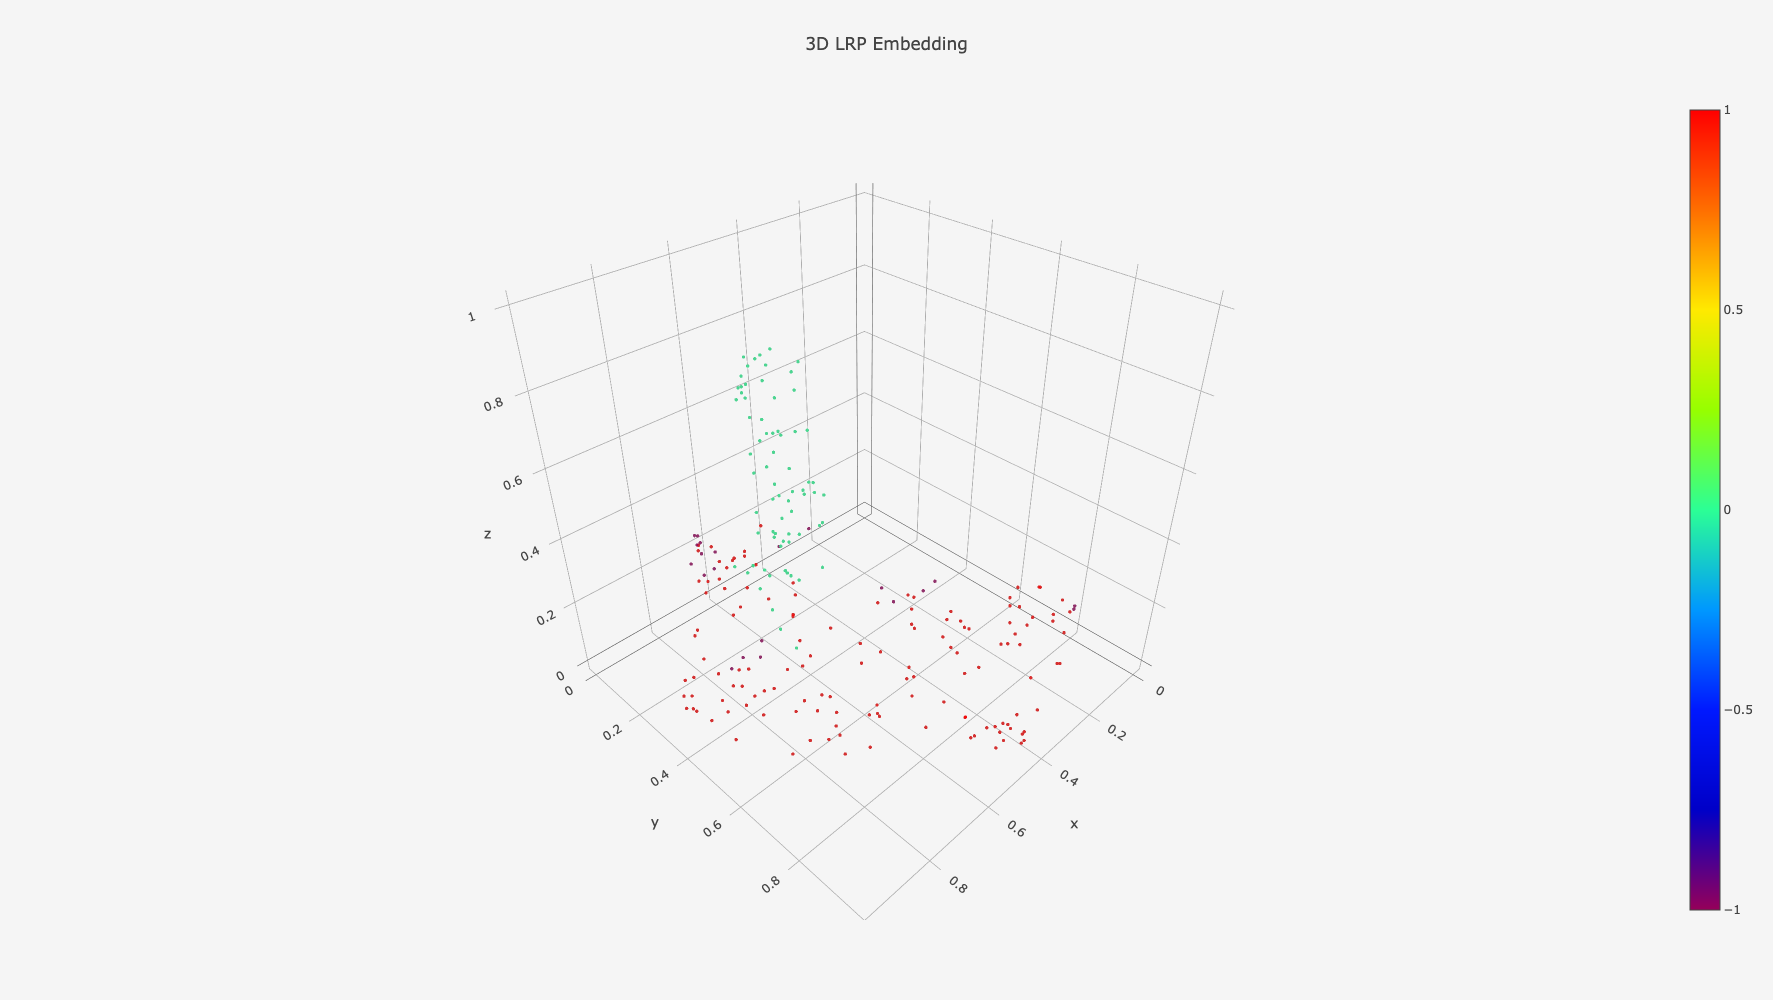

In [22]:
plot_clusters(pipeline)

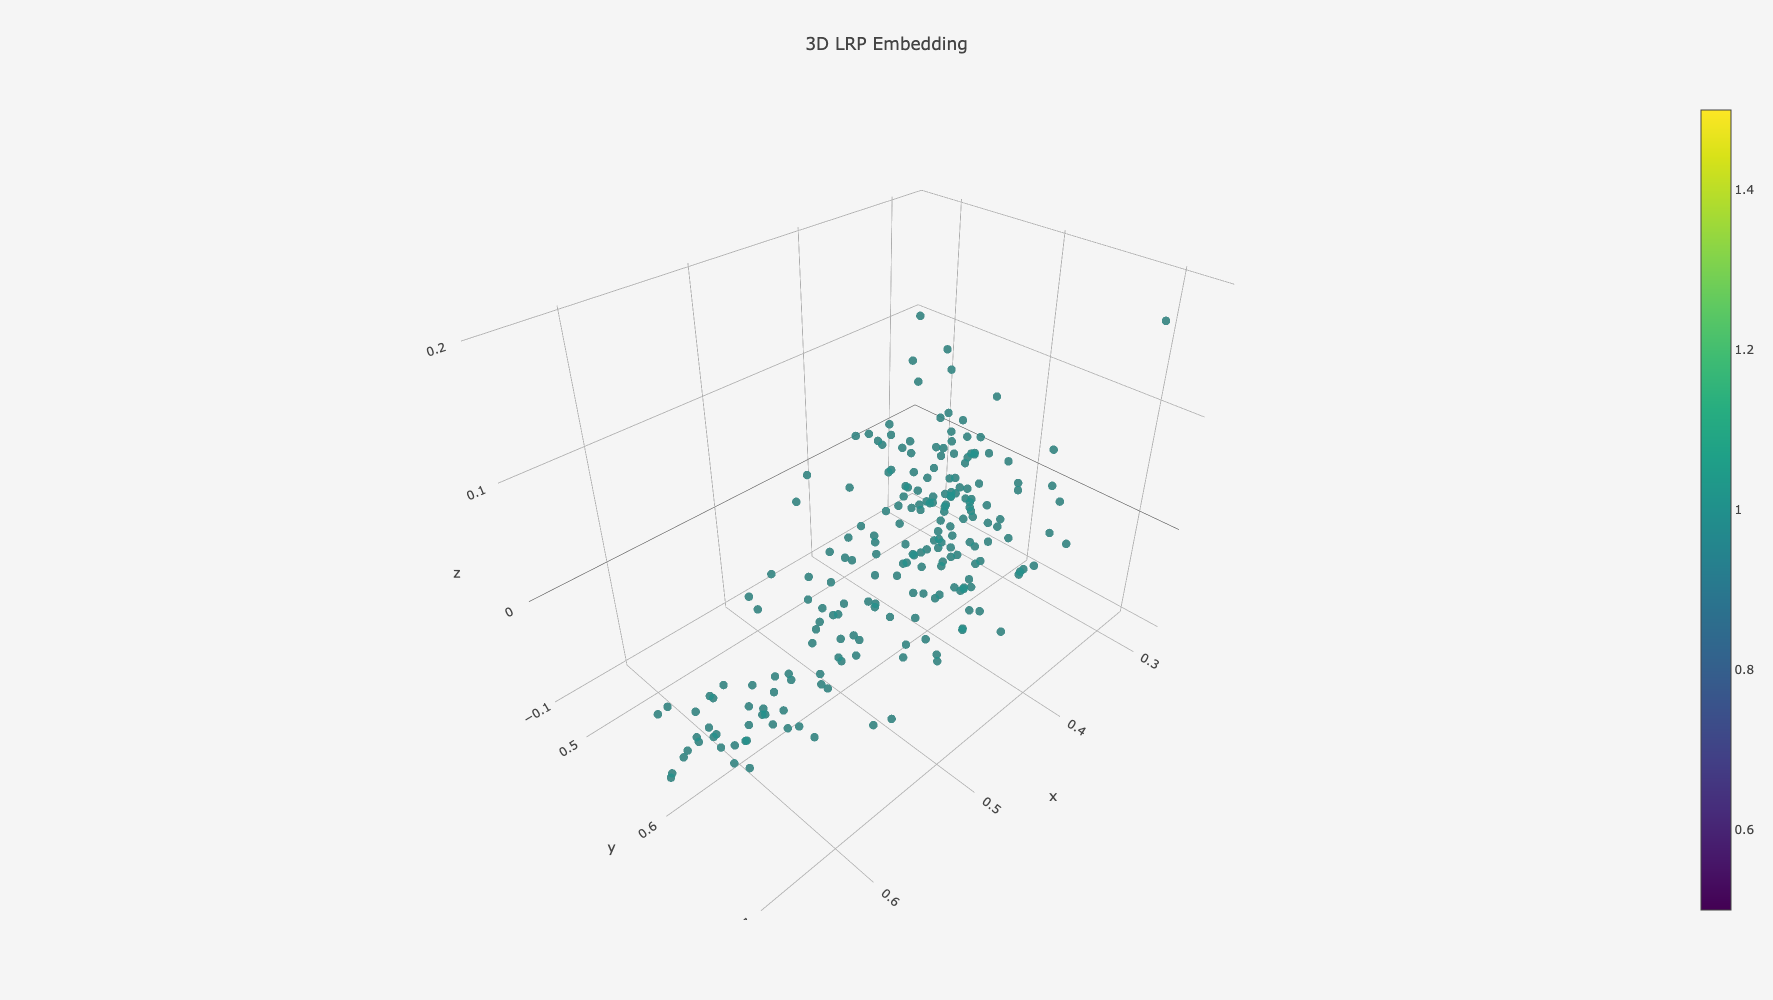

In [23]:


# pipeline.reducer_pipeline[0].n_neighbors
embedding_pipeline = Pipeline([
    ("reducer", umap.UMAP(random_state=42,
                    n_components = 3,
                    n_neighbors=97,
                    min_dist=0)),
   ("scaler", MinMaxScaler())
])

_, cluster_labels = pipeline.get_validation_clusters()
val_lrp = pipeline.val_set_lrp

embedding_pipeline.fit(pipeline.training_lrp)
val_3d_embedding = embedding_pipeline.transform(val_lrp)
val_3d_embedding = val_3d_embedding[cluster_labels > -1]

val_emb3d = go.Scatter3d(
    x=val_3d_embedding[:,0],
    y=val_3d_embedding[:,1],
    z=val_3d_embedding[:,2],
    name="Validation",
    mode="markers",
    marker=dict(
        size=5,
        color=cluster_labels[cluster_labels > -1],
        colorscale='Viridis',
        opacity=0.8,
        showscale=True
    ),
    text = cluster_labels[cluster_labels > -1]
)

layout = go.Layout(
    title="3D LRP Embedding",
    autosize=False,
    width=1200,
    height=1000,
    paper_bgcolor='#F5F5F5',
#     template="plotly"
)


data=[val_emb3d]

fig = go.Figure(data=data, layout=layout)
# fig.update_layout(template="plotly")  /

iplot(fig, filename='lrp-3d-scatter.html')

In [47]:
# Are the actual subclasses extracted?
# test_data, test_labels

In [24]:
test_data.shape

(500, 10)

In [25]:
# Internally populates self.val_set_lrp
val_samples_target, cluster_labels = pipeline.get_validation_clusters()

In [26]:
best_predictions, best_DNN = pipeline.get_predictions()

# Only consider the samples from the class(es) which are expected to have subclusters
target_class = best_predictions == pipeline.target_class
control_class = best_predictions != pipeline.target_class

val_samples_control = pipeline.val_set.features.values[pipeline.val_pred_mask][control_class]
control_labels = pipeline.val_set.labels.values[pipeline.val_pred_mask][control_class]

original_labels = test_labels[pipeline.val_pred_mask][target_class]

original_labels = original_labels[cluster_labels > -1]
clustered_labels = cluster_labels[cluster_labels > -1]

Prediction Accuracy: 0.9560


In [27]:
print("Control:", val_samples_control.shape)
print("Target:", val_samples_target.shape)

Control: (245, 10)
Target: (233, 10)


# TODO: Check if subclusters match with original classes

In [28]:
val_3d_embedding.shape

(213, 3)

In [29]:
clustered_labels.shape

(213,)

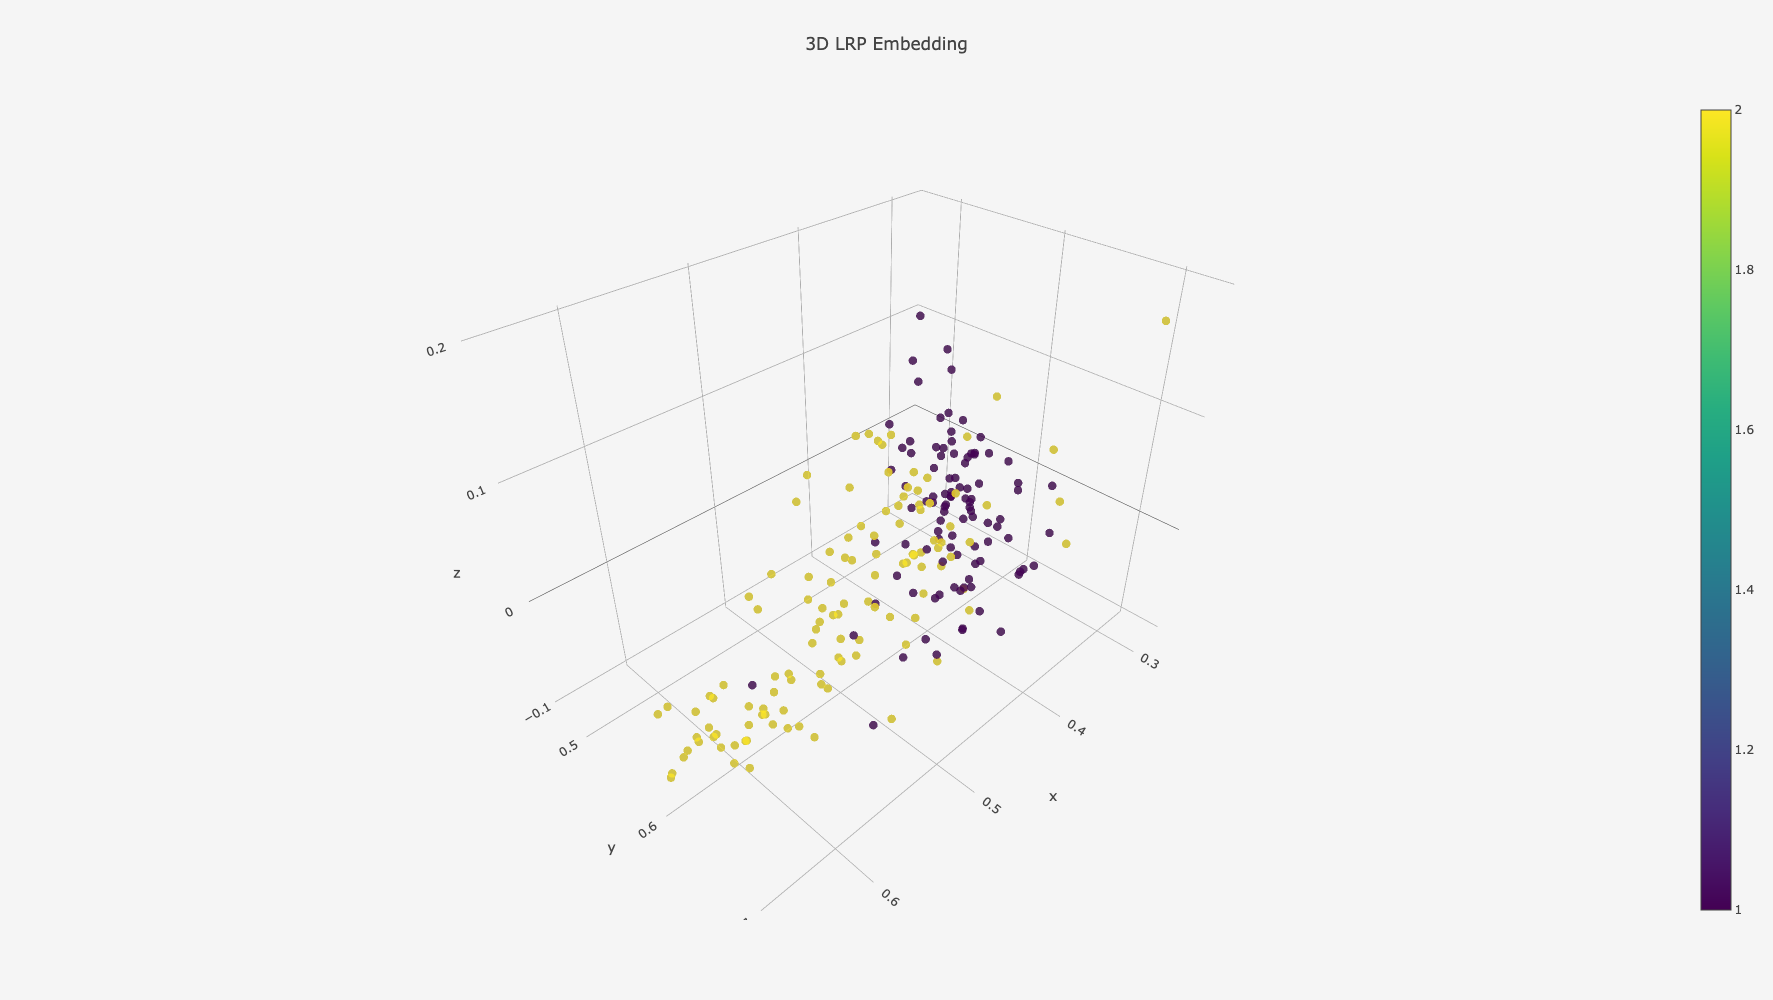

In [30]:
val_emb3d["marker"]["color"] = original_labels

data=[val_emb3d]

fig = go.Figure(data=data, layout=layout)
# fig.update_layout(template="plotly")  /
iplot(fig, filename='lrp-3d-scatter.html')

In [55]:
all(pipeline.val_set.labels.index == test_labels.index)

True

In [56]:
pd.Series(clustered_labels).value_counts()

1    1837
0    1217
dtype: int64

In [57]:
pd.Series(original_labels).value_counts()

1    1601
2    1453
dtype: int64

In [58]:
from sklearn import metrics

labels_true = original_labels.copy()
labels_pred = clustered_labels.copy()

In [59]:
print("Pipeline Score:", metrics.adjusted_mutual_info_score(labels_true, labels_pred))
print("Max Score:", metrics.adjusted_mutual_info_score(labels_true, labels_true))

Pipeline Score: 0.24498274331026074
Max Score: 1.0


/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



In [60]:
print("Pipeline Score:", metrics.adjusted_rand_score(labels_true, labels_pred))
print("Max Score:", metrics.adjusted_rand_score(labels_true, labels_true))

Pipeline Score: 0.2873745440088713
Max Score: 1.0


In [61]:
print("Completeness:", metrics.completeness_score(labels_true, labels_pred))

print("Homogeneity:", metrics.homogeneity_score(labels_true, labels_pred))

print("V-Measure:", metrics.v_measure_score(labels_true, labels_pred))

Completeness: 0.2522991483004276
Homogeneity: 0.2451614724478847
V-Measure: 0.2486791038922246


## Looking at classes separately

In [62]:
labels_true = original_labels[original_labels == 1]
labels_pred = clustered_labels[original_labels == 1]

In [63]:
labels_true.value_counts()

1    1601
dtype: int64

In [64]:
pd.Series(labels_pred).value_counts()

0    1055
1     546
dtype: int64

In [65]:
labels_true = original_labels[original_labels == 2]
labels_pred = clustered_labels[original_labels == 2]

In [66]:
labels_true.value_counts()

2    1453
dtype: int64

In [67]:
pd.Series(labels_pred).value_counts()

1    1291
0     162
dtype: int64

In [74]:
print("Pipeline Score:", metrics.adjusted_mutual_info_score(labels_true, labels_pred))
print("Max Score:", metrics.adjusted_mutual_info_score(labels_true, labels_true))

Pipeline Score: -3.175455062149024e-16
Max Score: 1.0


/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



In [70]:
print("Pipeline Score:", metrics.adjusted_rand_score(labels_true, labels_pred))
print("Max Score:", metrics.adjusted_rand_score(labels_true, labels_true))

Pipeline Score: 0.0
Max Score: 1.0


In [71]:
metrics.completeness_score(labels_true, labels_pred) 

-3.175455062149024e-16

In [72]:
metrics.homogeneity_score(labels_true, labels_pred)

1.0

In [254]:
# import keras

# keras.backend.softmax(pipeline.training_lrp)

# import tensorflow as tf

# with tf.Session() as sess:
#     print(sess.run(x))

In [1]:
pipeline.training_lrp

NameError: name 'pipeline' is not defined

In [ ]:
# AMI: 0.3924923198739669
# ARand: 0.4547043752052252
# Completeness: 0.41951806663066016
# Homogeneity: 0.3926861598546202
# V-Measure: 0.4056589049966344